In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

In [2]:
plt.rcParams['figure.figsize']=(10,8)

In [3]:
pd.__version__

'0.15.2'

In [4]:
cd /Volumes/divaye/backup/data/diviner/ground_calib/

/Volumes/divaye/backup/data/diviner/ground_calib


In [5]:
ls *.h5

all_data.h5           gc_a6_b1_b2_b3.h5     house_keeping.h5      telB_ground_calib.h5


In [6]:
data = pd.read_hdf('./telB_ground_calib.h5', 'df')
data[data < -9998] = np.nan
data.dropna(how='all', inplace=True)

## NaN
NaN is marked as -9999. To be sure to catch float values, I mark everything NaN that is lower than -9998.

In [7]:
hk = pd.read_hdf('./house_keeping.h5','df')
hk[hk < -9998] = np.nan
#hk.dropna(how='all', inplace=True)

Some of the bad data has been correctly marked by the `TEMP_FAULT` column, so it will be marked as Nan as well

In [8]:
hk[hk['TEMP_FAULT'] == 1]=np.nan

In [9]:
hk.LAST_EL_CMD.value_counts(dropna=False)

 75.96     63145
 0.00      37062
 111.01    35971
-101.01      522
NaN           71
 180.00       15
dtype: int64

In [10]:
%matplotlib qt

# Elevation command probs


some of the NaN'ed elevation commands are needed to guide the calibration.
padding them with the previous value seems to work fine, I checked that it at least
does not do anything stupid in the 10K test until the data is clean.

In [11]:
plt.figure()
hk.LAST_EL_CMD.plot(legend=True)

In [49]:
hk.LAST_EL_CMD = hk.LAST_EL_CMD.fillna(method='pad')

In [50]:
t_cols = hk.filter(regex='TEMP').columns
t_cols = t_cols.drop("TEMP_FAULT")
t_cols = [i for i in t_cols if not i.endswith('_CYC')]
t_cols

['FPA_TEMP',
 'FPB_TEMP',
 'BAFFLE_A_TEMP',
 'BAFFLE_B_TEMP',
 'BB_1_TEMP',
 'OBA_1_TEMP',
 'HYBRID_TEMP',
 'OBA_2_TEMP',
 'BB_2_TEMP',
 'SOLAR_TARGET_TEMP',
 'YOKE_TEMP',
 'EL_ACTUATOR_TEMP',
 'AZ_ACTUATOR_TEMP',
 'SOLAR_BASE_TEMP']

In [51]:
hk_temps = hk[t_cols]

# Spikes
Some of the temperatures contain spikes that need to be cleaned.

In [52]:
#spike cleaning
for col in t_cols:
    hk.loc[hk_temps[col].diff() > 1, col] = np.nan

#### Commented out next cell, b/c it's big plot!

In [53]:

# for col in t_cols:
#     hk_temps[col].dropna().plot(label=col)
# plt.legend(ncol=2,loc='best')

In [54]:
t_10K_start = '2008-01-10 21'
t_10K_end = '2008-01-12 20'
# using a conservative cut-off area here to stay with clean measurements
t_10K_end_clean = '20080112 13:30'
t_30K_start = '20080112 23:30'
t_30K_end = '20080113 15:15'
t_60K_start = '20080114 11:00'
t_60K_end = '20080115 02:50'
# set start and end times here:
start = t_10K_start
end = t_10K_end_clean

In [55]:
#for col in t_cols:
#    hk_temps[start:end][col].dropna().plot(label=col, rasterized=True)
#plt.legend(ncol=2, loc='best')

In [56]:
t_cols_telA = 'FPA_TEMP BAFFLE_A_TEMP BB_1_TEMP OBA_1_TEMP'.split()
t_cols_telB = 'FPB_TEMP BAFFLE_B_TEMP BB_2_TEMP OBA_2_TEMP'.split()
t_cols_common = set(t_cols) - set(t_cols_telA) - set(t_cols_telB)
t_cols_telA.extend(t_cols_common)
t_cols_telB.extend(t_cols_common)
t_cols_telB

['FPB_TEMP',
 'BAFFLE_B_TEMP',
 'BB_2_TEMP',
 'OBA_2_TEMP',
 'EL_ACTUATOR_TEMP',
 'AZ_ACTUATOR_TEMP',
 'YOKE_TEMP',
 'SOLAR_TARGET_TEMP',
 'HYBRID_TEMP',
 'SOLAR_BASE_TEMP']

### Prepping data

In [57]:
from diviner import ground_calib

In [58]:
ground_calib.data_prep(data, hk)

### Merging

I will be merging the more frequent `data` dataframe into the less frequent HK dataframe. That way I don't need to interpolate the less frequent H/K-data to the frequency of the science data.

In [59]:
telB_temps = hk_temps.loc[start:end, t_cols]

In [60]:
from diviner.calib import thermal_detectors

In [61]:
data.rename(columns = lambda x: x.lower(), inplace=True)

In [66]:
merged = telB_temps.join(data[thermal_detectors[-63:]+['sdtype','last_az_cmd',
                               'last_el_cmd','is_calib','is_spaceview',
                               'is_bbview','calib_block_labels','bb_block_labels',
                               'space_block_labels','is_stview', 'st_block_labels','is_moving']])

In [67]:
merged.columns

Index([u'FPA_TEMP', u'FPB_TEMP', u'BAFFLE_A_TEMP', u'BAFFLE_B_TEMP', u'BB_1_TEMP', u'OBA_1_TEMP', u'HYBRID_TEMP', u'OBA_2_TEMP', u'BB_2_TEMP', u'SOLAR_TARGET_TEMP', u'YOKE_TEMP', u'EL_ACTUATOR_TEMP', u'AZ_ACTUATOR_TEMP', u'SOLAR_BASE_TEMP', u'b1_01', u'b1_02', u'b1_03', u'b1_04', u'b1_05', u'b1_06', u'b1_07', u'b1_08', u'b1_09', u'b1_10', u'b1_11', u'b1_12', u'b1_13', u'b1_14', u'b1_15', u'b1_16', u'b1_17', u'b1_18', u'b1_19', u'b1_20', u'b1_21', u'b2_01', u'b2_02', u'b2_03', u'b2_04', u'b2_05', u'b2_06', u'b2_07', u'b2_08', u'b2_09', u'b2_10', u'b2_11', u'b2_12', u'b2_13', u'b2_14', u'b2_15', u'b2_16', u'b2_17', u'b2_18', u'b2_19', u'b2_20', u'b2_21', u'b3_01', u'b3_02', u'b3_03', u'b3_04', u'b3_05', u'b3_06', u'b3_07', u'b3_08', u'b3_09', u'b3_10', u'b3_11', u'b3_12', u'b3_13', u'b3_14', u'b3_15', u'b3_16', u'b3_17', u'b3_18', u'b3_19', u'b3_20', u'b3_21', u'sdtype', u'last_az_cmd', u'last_el_cmd', u'is_calib', u'is_spaceview', u'is_bbview', u'calib_block_labels', u'bb_block_labels',

In [68]:
plt.style.use('bmh')
plt.figure()
for col in t_cols_telB:
    merged[merged.sdtype==0][col].dropna().plot(label=col,linewidth=2)
plt.ylabel('Temperature [K]')
plt.legend(ncol=2, loc='lower left')
merged[merged.is_spaceview].b3_11.plot(legend=False, style='.',
                                    secondary_y=True, color='blue')
merged[merged.is_bbview].b3_11.plot(legend=False, style='.',
                                    secondary_y=True, color='red')
merged[merged.sdtype==0].b3_11.plot(legend=False, style='.',
                                    secondary_y=True, color='green')
plt.title('b3_11 DATA[green], SPACE[blue], BB[red] vs H/K temps')
plt.ylabel('Counts [b3_11]');

In [69]:
plt.figure()
merged[merged.is_spaceview].b3_11.plot(legend=False, style='.',
                                    secondary_y=True, color='blue')
merged[merged.is_bbview].b3_11.plot(legend=False, style='.',
                                    secondary_y=True, color='red')
merged[merged.sdtype==0].b3_11.plot(legend=False, style='.',
                                    secondary_y=True, color='green')
plt.title('b3_11 DATA[green], SPACE[blue], BB[red] vs H/K temps')
plt.ylabel('Counts [b3_11]');

In [29]:
from diviner.ground_calib import PolyScaler

In [30]:
rowmask = merged.sdtype==0

In [123]:
tofit = thermal_detectors[-21:]

In [124]:
tofit.remove('b3_11')

In [132]:
for det in tofit[:1]:
    polyscaler = PolyScaler(merged[mask][det], merged[mask]['b3_11'])
    polyscaler.do_fit()
    merged.loc[mask, det+'_fit'] = polyscaler.scaled

In [136]:
merged[start:end][mask]['b3_01 b3_01_fit b3_11'.split()].plot()

In [31]:
from diviner import calib

In [32]:
for det in calib.tel_A_detectors:
    merged.loc[:, det] = 0

In [33]:
merged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 71101 entries, 2008-01-10 21:00:01.980000 to 2008-01-12 13:30:59.482000
Columns: 215 entries, fpa_temp to a6_21
dtypes: bool(5), float64(79), int32(4), int64(127)
memory usage: 113.7 MB


In [34]:
c = calib.Calibrator(merged.iloc[:10000])

INFO:diviner.calib:Calibrating from 2008-01-10 21:00:01.980000 to 2008-01-11 02:41:19.780000.


In [ ]:
c.calibrate()

INFO:diviner.calib:Found less than 2 SPACE labels in CalBlock at 2008-01-10 21:00:01.980000.
INFO:diviner.calib:Found less than 2 SPACE labels in CalBlock at 2008-01-10 21:00:04.028000.
INFO:diviner.calib:Found less than 2 SPACE labels in CalBlock at 2008-01-10 21:00:06.076000.
INFO:diviner.calib:Found less than 2 SPACE labels in CalBlock at 2008-01-10 21:00:08.124000.
INFO:diviner.calib:Found less than 2 SPACE labels in CalBlock at 2008-01-10 21:00:10.172000.
INFO:diviner.calib:Found less than 2 SPACE labels in CalBlock at 2008-01-10 21:00:12.220000.
INFO:diviner.calib:Found less than 2 SPACE labels in CalBlock at 2008-01-10 21:00:55.227000.
INFO:diviner.calib:Found less than 2 SPACE labels in CalBlock at 2008-01-10 21:00:57.275000.
INFO:diviner.calib:Found less than 2 SPACE labels in CalBlock at 2008-01-10 21:00:59.323000.
INFO:diviner.calib:Found less than 2 SPACE labels in CalBlock at 2008-01-10 21:01:01.371000.
INFO:diviner.calib:Found less than 2 SPACE labels in CalBlock at 2008-

In [146]:
merged.columns

Index([u'FPB_TEMP', u'BAFFLE_B_TEMP', u'BB_2_TEMP', u'OBA_2_TEMP', u'EL_ACTUATOR_TEMP', u'AZ_ACTUATOR_TEMP', u'YOKE_TEMP', u'SOLAR_TARGET_TEMP', u'HYBRID_TEMP', u'SOLAR_BASE_TEMP', u'b1_01', u'b1_02', u'b1_03', u'b1_04', u'b1_05', u'b1_06', u'b1_07', u'b1_08', u'b1_09', u'b1_10', u'b1_11', u'b1_12', u'b1_13', u'b1_14', u'b1_15', u'b1_16', u'b1_17', u'b1_18', u'b1_19', u'b1_20', u'b1_21', u'b2_01', u'b2_02', u'b2_03', u'b2_04', u'b2_05', u'b2_06', u'b2_07', u'b2_08', u'b2_09', u'b2_10', u'b2_11', u'b2_12', u'b2_13', u'b2_14', u'b2_15', u'b2_16', u'b2_17', u'b2_18', u'b2_19', u'b2_20', u'b2_21', u'b3_01', u'b3_02', u'b3_03', u'b3_04', u'b3_05', u'b3_06', u'b3_07', u'b3_08', u'b3_09', u'b3_10', u'b3_11', u'b3_12', u'b3_13', u'b3_14', u'b3_15', u'b3_16', u'b3_17', u'b3_18', u'b3_19', u'b3_20', u'b3_21', u'sdtype', u'last_az_cmd', u'last_el_cmd', u'is_calib', u'is_spaceview', u'is_bbview', u'calib_block_labels', u'bb_block_labels', u'space_block_labels', u'b3_01_fit', u'a1_01', u'a1_02', u'

In [26]:
[i for i in hk.columns if not 'COMMAND' in i]

['Q',
 'DATE',
 'UTC',
 'SCLK',
 'PKT_COUNT',
 'SAFING',
 'SAFED',
 'FREEZING',
 'FROZEN',
 'ROLLING',
 'DUMPING',
 'MOVING',
 'TEMP_FAULT',
 'SC_TIME_SECS',
 'SC_TIME_SUBS',
 'TICKS_PKT_START',
 'TICKS_AT_SC_TIME',
 'OST_INDEX',
 'EST_INDEX',
 'SST_INDEX',
 'LAST_AZ_CMD',
 'LAST_EL_CMD',
 'FPA_TEMP',
 'FPB_TEMP',
 'BAFFLE_A_TEMP',
 'BAFFLE_B_TEMP',
 'BB_1_TEMP',
 'OBA_1_TEMP',
 'ERROR_TIME',
 'ERROR_ID',
 'ERROR_DETAIL',
 'ERROR_COUNT',
 'CMD',
 'REQ_ID',
 'LAST_EQX_PREDICTION',
 'HYBRID_TEMP',
 'FPA_TEMP_CYC',
 'FPB_TEMP_CYC',
 'BAFFLE_A_TEMP_CYC',
 'BAFFLE_B_TEMP_CYC',
 'OBA_1_TEMP_CYC',
 'OBA_2_TEMP',
 'BB_1_TEMP_CYC',
 'BB_2_TEMP',
 'SOLAR_TARGET_TEMP',
 'YOKE_TEMP',
 'EL_ACTUATOR_TEMP',
 'AZ_ACTUATOR_TEMP',
 'MIN_15V',
 'PLU_15V',
 'SOLAR_BASE_TEMP',
 'PLU_5V',
 'A1_01av',
 'A1_02av',
 'A1_03av',
 'A1_04av',
 'A1_05av',
 'A1_06av',
 'A1_07av',
 'A1_08av',
 'A1_09av',
 'A1_10av',
 'A1_11av',
 'A1_12av',
 'A1_13av',
 'A1_14av',
 'A1_15av',
 'A1_16av',
 'A1_17av',
 'A1_18av',
 'A1_1

In [70]:
merged[merged.is_spaceview]['b3_11'].plot(style='.',color='blue')
merged[merged.is_bbview]['b3_11'].plot(style='.',color='red')

In [29]:
merged.iloc[-1000:]['b3_11 sdtype'.split()].plot(secondary_y='sdtype',style='.-')

Does the merging go wrong or is there last_elevation data missing?

In [75]:
t1 = '2008-01-10 21:55'
t2 = '2008-01-10 21:56'
toplot = merged[merged.sdtype>-1][t1:t2]
plt.rcParams['lines.markersize']=16
toplot[toplot['is_spaceview']]['b3_11'].plot(color='blue',style='*',
                                             title='Red:BB, Blue:Space, Green:Science')
toplot[toplot['is_bbview']]['b3_11'].plot(color='red', style='*')
toplot[~toplot.is_calib]['b3_11'].plot(color='green', style='*')
toplot.last_el_cmd.plot(color='black', style='.-', secondary_y=True, legend=True)

In [31]:
toplot.last_el_cmd[t1:t2].plot(style='.', secondary_y=True)

In [32]:
data.last_el_cmd[t1:t2].value_counts()

75.96     23
0.00      18
111.01    17
dtype: int64

# Marc Foote's chamber data parsing

In [10]:
cd ~/Dropbox/DDocuments/DIVINER/ground_calib/

/Users/klay6683/Dropbox/DDocuments/DIVINER/ground_calib


In [11]:
df = pd.read_hdf('chamberdata.h5','df')

In [12]:
df.set_index('Time', inplace=True)

In [14]:
col = df.columns[3]

In [15]:
col

u'BB2 T'

In [16]:
%matplotlib inline

In [26]:
[i for i in plt.rcParams.keys() if 'offset' in i]

[u'axes.formatter.useoffset']

In [27]:
plt.rcParams['axes.formatter.useoffset'] = False

In [43]:
%matplotlib qt

In [45]:
df[col].plot(ax=ax) #, style='.')

In [18]:
hk['BB_2_spike'] = hk.BB_2_TEMP.dropna().diff() > 0.5

In [19]:
hk.BB_2_spike.value_counts()

False    11842
True         1
dtype: int64

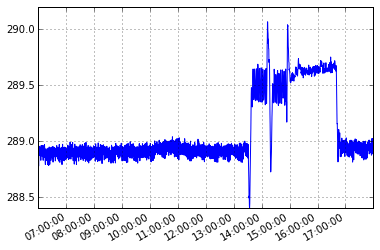

In [39]:
hk['20080112 06':'20080112 17'].BB_2_TEMP.dropna().plot()